In [1]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
# handling file paths
import os
# handling data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras

# to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# pre trained models to use for transfer learning
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16

# To preprocess images
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess

# Blocks for model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# early stopping and saving best model and reducing learning rate if plateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# String processing
import re

# logger
import logging
tf.get_logger().setLevel(logging.ERROR)

# Pre Check

Checking version, if gpus are available or not, can we do mixed precision for time optimization

tf.data.AUTOTUNE automatically tunes performance for data loading

In [3]:
# checking for Mixed Precision for optimization
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Mixed Precision:', mixed_precision.global_policy().name)
except Exception as e:
    print(f"Could not set mixed precision: {e}")


# Pre check
print("tf Version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu_devices))
if gpu_devices:
    print("GPUs found:", gpu_devices)
else:
    print("No GPU detected")

AUTOTUNE = tf.data.AUTOTUNE


Mixed Precision: mixed_float16
tf Version: 2.18.0
GPUs Available:  1
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Config

Setting important global varibales such as img size, data path, batch size, L2, dropout, etc


batch size : why to keep it small?
Pros:

Better generalization: Introduces noise in gradient estimates, which can help escape local minima and overfitting.

Lower memory usage: Good for limited GPU memory.

Frequent updates: More weight updates per epoch.

# REGARDING BATCH SIZE

"You can try any batch size, but a batch size of 5 seems reasonable"

Batch size of 5 is not reasonable. Tested from my previous multiple runs - this batch size is too low.

It is true that lower batch could help model to generalize more, update weights more often, and fine tune as lower batch adds a noise as model is only able to see that many samples at a time but if it is too low then that noise itself can lead to UNSTABLE training, and poor gradient estimates.

Batch size cannot be too high as well is bad, model wont be able to generalize as it is able to larger chunk of the sample population

I think, batch size of 16-24 is more reasonable and as per my multiple training it gives better results as well
(also taking 2's power is preferable and considered good practice but not necessary. 2's power is easy to store wrt bits thus reduction in steps per calculation but optional )

In [4]:
# Gathering and Understanding Our Photos (Data Config & Loading)

# Config
DATASET_PATH = "/content/drive/MyDrive/RealWaste/"

# image
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# training
# taking batch size w.r.t. to 2's power
BATCH_SIZE = 16

# times the model will go through the entire training dataset
EPOCHS = 100
# if validation performance doesn't improve then stop
# value 5-8 seems reasonable to be based on my numerous prior testing
EARLY_STOPPING_PATIENCE = 7

# L2 penalty helps prevent overfitting
L2_REG = 1e-3

# percentage of neurons to randomly turn off during training in dropout layers.
DROPOUT_RATE = 0.3

# Splitting
# Project asks us to do 80-20 split
# taking 15% of the train data as validation out 80%
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.2

# Fetching sub directories - classes


In [5]:
# waste categories
try:
    all_items_in_dataset_path = os.listdir(DATASET_PATH)
    CLASS_NAMES = sorted([item for item in all_items_in_dataset_path if os.path.isdir(os.path.join(DATASET_PATH, item))])
    NUM_CLASSES = len(CLASS_NAMES)

    if NUM_CLASSES == 0:
        raise ValueError("No class folders")
    print(f"Successfully found {NUM_CLASSES} waste categories:")
    for i, name in enumerate(CLASS_NAMES):
        print(f" Class {i}: {name}")
except Exception as e:
    print(e)
    raise

Successfully found 9 waste categories:
 Class 0: 1-Cardboard
 Class 1: 2-Food Organics
 Class 2: 3-Glass
 Class 3: 4-Metal
 Class 4: 5-Miscellaneous Trash
 Class 5: 6-Paper
 Class 6: 7-Plastic
 Class 7: 8-Textile Trash
 Class 8: 9-Vegetation


# Listing All Image Files and Their Labels

We need to create a list of every single image file and what type of waste it is. we will store full path to the image and its text label

In [6]:
all_filepaths = []
all_labels_text = []

print(f"\nScanning images: {DATASET_PATH}")
for class_name in CLASS_NAMES:
    class_folder_path = os.path.join(DATASET_PATH, class_name)
    image_filenames_in_class = os.listdir(class_folder_path)

    images_found_in_class = 0
    for image_filename in image_filenames_in_class:
        # Check image format
        if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            full_image_path = os.path.join(class_folder_path, image_filename)
            all_filepaths.append(full_image_path)
            # label = namae of the folder
            all_labels_text.append(class_name)
            images_found_in_class += 1
    print(f"  Found {images_found_in_class} images in class folder: '{class_name}'")

if not all_filepaths:
    raise ValueError(f"No image files were found")

print(f"\nTotal images found for all classes: {len(all_filepaths)}")



Scanning images: /content/drive/MyDrive/RealWaste/
  Found 461 images in class folder: '1-Cardboard'
  Found 411 images in class folder: '2-Food Organics'
  Found 420 images in class folder: '3-Glass'
  Found 790 images in class folder: '4-Metal'
  Found 495 images in class folder: '5-Miscellaneous Trash'
  Found 500 images in class folder: '6-Paper'
  Found 921 images in class folder: '7-Plastic'
  Found 318 images in class folder: '8-Textile Trash'
  Found 436 images in class folder: '9-Vegetation'

Total images found for all classes: 4752


# Inserting above data into Dataframe

In [7]:
image_data_df = pd.DataFrame({
    'filepath': all_filepaths,
    'label_text': all_labels_text
})

print(image_data_df.head())
print()
print(image_data_df['label_text'].value_counts())


                                            filepath   label_text
0  /content/drive/MyDrive/RealWaste/1-Cardboard/C...  1-Cardboard
1  /content/drive/MyDrive/RealWaste/1-Cardboard/C...  1-Cardboard
2  /content/drive/MyDrive/RealWaste/1-Cardboard/C...  1-Cardboard
3  /content/drive/MyDrive/RealWaste/1-Cardboard/C...  1-Cardboard
4  /content/drive/MyDrive/RealWaste/1-Cardboard/C...  1-Cardboard

label_text
7-Plastic                921
4-Metal                  790
6-Paper                  500
5-Miscellaneous Trash    495
1-Cardboard              461
9-Vegetation             436
3-Glass                  420
2-Food Organics          411
8-Textile Trash          318
Name: count, dtype: int64


# Splitting Data - Training, Validation, and Test Sets
Project Requirement states that, "Select the first 80% of the images in each folder as training set and the rest as the test set."

to do this we are sorting images_1, images_2 filenames, taking first 80% as training

Remaining bottom 20% is test

out of 80% of the train data - taking 20% random validation

In [8]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

train_val_filepaths = []
train_val_labels_text = []
test_filepaths = []
test_labels_text = []

print(f"\nScanning {DATASET_PATH} and splitting per folder...")
for class_name in CLASS_NAMES:
    class_folder_path = os.path.join(DATASET_PATH, class_name)

    image_filenames_in_class_unsorted = [
        f for f in os.listdir(class_folder_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
    ]

    if not image_filenames_in_class_unsorted:
        continue

    # Sort files - img1, img2, ..., img10....
    image_filenames_in_class_sorted = sorted(image_filenames_in_class_unsorted, key=natural_sort_key)

    num_images_in_class = len(image_filenames_in_class_sorted)

    if num_images_in_class == 0:
        continue
    elif num_images_in_class == 1:
        split_idx = 1
    elif num_images_in_class < 5 :
        split_idx = num_images_in_class - 1
    else:
        split_idx = int(num_images_in_class * 0.80)

    if split_idx == 0 and num_images_in_class > 0:
        split_idx = 1
    if split_idx == num_images_in_class and num_images_in_class > 1:
        split_idx = num_images_in_class -1


    # First 80% to train_val set
    current_class_train_val_files = image_filenames_in_class_sorted[:split_idx]
    # Remaining 20% to test set
    current_class_test_files = image_filenames_in_class_sorted[split_idx:]

    for fname in current_class_train_val_files:
        train_val_filepaths.append(os.path.join(class_folder_path, fname))
        train_val_labels_text.append(class_name)

    for fname in current_class_test_files:
        test_filepaths.append(os.path.join(class_folder_path, fname))
        test_labels_text.append(class_name)

    print(f"Class '{class_name}': {num_images_in_class} images -> "
          f"{len(current_class_train_val_files)} for Train/Val, "
          f"{len(current_class_test_files)} for Test.")

if not train_val_filepaths:
    raise ValueError(f"No images were allocated")
if not test_filepaths:
    print(f"Warning: No images were allocated")


train_val_df = pd.DataFrame({
    'filepath': train_val_filepaths,
    'label_text': train_val_labels_text
})

if test_filepaths:
    test_df = pd.DataFrame({
        'filepath': test_filepaths,
        'label_text': test_labels_text
    })
else:
    test_df = pd.DataFrame(columns=['filepath', 'label_text'])


print(f"\nTotal images initially for Train/Validation: {len(train_val_df)}")
print(f"Total images for Test: {len(test_df)}")

if len(train_val_df) > 0:
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VALIDATION_SPLIT_RATIO,
        random_state=42,
        stratify=train_val_df['label_text']
    )
else:
    train_df = pd.DataFrame(columns=['filepath', 'label_text'])
    val_df = pd.DataFrame(columns=['filepath', 'label_text'])

total_original_images = len(train_df) + len(val_df) + len(test_df)

print(f"Total original images: {total_original_images}")
print(f"Training set size:     {len(train_df)}")
print(f"Validation set size:   {len(val_df)}")
print(f"Test set size:         {len(test_df)}")

if not train_df.empty:
    print("\nClass distribution in Final Training set:")
    print(train_df['label_text'].value_counts(normalize=True))
if not val_df.empty:
    print("\nClass distribution in Final Validation set:")
    print(val_df['label_text'].value_counts(normalize=True))
if not test_df.empty:
    print("\nClass distribution in Final Test set:")
    print(test_df['label_text'].value_counts(normalize=True))
else:
    print("\nTest set is empty.")


Scanning /content/drive/MyDrive/RealWaste/ and splitting per folder...
Class '1-Cardboard': 461 images -> 368 for Train/Val, 93 for Test.
Class '2-Food Organics': 411 images -> 328 for Train/Val, 83 for Test.
Class '3-Glass': 420 images -> 336 for Train/Val, 84 for Test.
Class '4-Metal': 790 images -> 632 for Train/Val, 158 for Test.
Class '5-Miscellaneous Trash': 495 images -> 396 for Train/Val, 99 for Test.
Class '6-Paper': 500 images -> 400 for Train/Val, 100 for Test.
Class '7-Plastic': 921 images -> 736 for Train/Val, 185 for Test.
Class '8-Textile Trash': 318 images -> 254 for Train/Val, 64 for Test.
Class '9-Vegetation': 436 images -> 348 for Train/Val, 88 for Test.

Total images initially for Train/Validation: 3798
Total images for Test: 954
Total original images: 4752
Training set size:     3038
Validation set size:   760
Test set size:         954

Class distribution in Final Training set:
label_text
7-Plastic                0.193878
4-Metal                  0.166557
6-Paper

# Preprocessing & tf.data Pipelines


We also need to make sure all images are the same size.
tf.data is an efficient way to load and prepare data for TensorFlow models.

## one hot encoding

Our model's output layer will have one neuron per class.

We need to convert labels like "1-Cardboard" to something like [1, 0, 0, 0, 0, 0, 0, 0, 0].


In [9]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(CLASS_NAMES)

# transform the text labels in our dataframes to one-hot arrays
train_labels_one_hot = label_binarizer.transform(train_df['label_text'].values)
val_labels_one_hot = label_binarizer.transform(val_df['label_text'].values)
test_labels_one_hot = label_binarizer.transform(test_df['label_text'].values)

print(f"Example: '{train_df['label_text'].iloc[0]}' becomes one-hot: {train_labels_one_hot[0]}")
ORDERED_CLASS_NAMES_FROM_BINARIZER = label_binarizer.classes_.tolist()
print("Class: ", ORDERED_CLASS_NAMES_FROM_BINARIZER)
if ORDERED_CLASS_NAMES_FROM_BINARIZER != CLASS_NAMES:
    print("Warning")

Example: '1-Cardboard' becomes one-hot: [1 0 0 0 0 0 0 0 0]
Class:  ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


# Imbalance handling

calculating and giving this class weight array to model.fit

data is slightly imbalance but ratio is within 3 thus going for this method instead of making each class of same size

In [10]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(CLASS_NAMES), # Must be the unique, sorted class names
    y=train_df['label_text'].values
)
class_weights_dict = {i : class_weights_array[i] for i, class_name in enumerate(CLASS_NAMES)}

class_indices = {class_name: i for i, class_name in enumerate(label_binarizer.classes_)}
final_class_weights_for_keras = {class_indices[class_name]: weight
                                 for class_name, weight in zip(label_binarizer.classes_, class_weights_array)}

print(final_class_weights_for_keras)

{0: np.float64(1.1481481481481481), 1: np.float64(1.2883799830364715), 2: np.float64(1.2548533663775299), 3: np.float64(0.6671058410188845), 4: np.float64(1.06484402383456), 5: np.float64(1.054861111111111), 6: np.float64(0.5730994152046783), 7: np.float64(1.6628352490421456), 8: np.float64(1.214228617106315)}


# Load, Resize, and Augment Images

This function will be the core of our data pipeline.
It takes a file path and its label, loads the image, resizes it,
optionally augments it "for training", and applies model-specific preprocessing.


In [11]:
def load_and_preprocess_image_tf(filepath_tensor, label_tensor, is_training_data, model_specific_preprocess_fn):
    image_binary_data = tf.io.read_file(filepath_tensor)
    try:
        image_tensor = tf.image.decode_jpeg(image_binary_data, channels=3)
    except tf.errors.InvalidArgumentError:
        image_tensor = tf.image.decode_image(image_binary_data, channels=3, expand_animations=False)

    # data Augmentation only for train
    # crop, zoom, rotate, flip, contrast, translate
    if is_training_data:
        # This gives a mild zoom/pan effect.
        intermediate_height = int(IMG_HEIGHT * 1.15)
        intermediate_width = int(IMG_WIDTH * 1.15)
        image_tensor = tf.image.resize(image_tensor, [intermediate_height, intermediate_width])
        image_tensor = tf.image.random_crop(image_tensor, size=[IMG_HEIGHT, IMG_WIDTH, 3])
        # size ensures the output is 224x224 after crop orzoom.

        # flip
        image_tensor = tf.image.random_flip_left_right(image_tensor)

        # rotate
        k_rot = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image_tensor = tf.image.rot90(image_tensor, k=k_rot)

        # contrast and brightness
        # lower upper is range of constrast and max_delta is maximum brightness
        image_tensor = tf.image.random_contrast(image_tensor, lower=0.8, upper=1.2)
        image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.15)

        # translate
        # max pixels to shit
        max_dx = IMG_WIDTH // 10
        max_dy = IMG_HEIGHT // 10

        # shifts
        dx = tf.random.uniform(shape=[], minval=-max_dx, maxval=max_dx, dtype=tf.int32)
        dy = tf.random.uniform(shape=[], minval=-max_dy, maxval=max_dy, dtype=tf.int32)

        # Padding
        # [[top, bottom], [left, right], [channel_top, channel_bottom]]
        # enough padding to accommodate the maximum possible shift in any direction
        # If dx is positive, we shift right thus it need left padding)
        # If dx is negative, we shift left thus need right padding
        pad_left = tf.maximum(0, -dx)
        pad_right = tf.maximum(0, dx)
        pad_top = tf.maximum(0, -dy)
        pad_bottom = tf.maximum(0, dy)

        image_tensor_padded = tf.pad(image_tensor, [[pad_top, pad_bottom],
                                    [pad_left, pad_right], [0,0]], mode='REFLECT')
        offset_x = tf.maximum(0, dx)
        offset_y = tf.maximum(0, dy)

        # This ensures the output image_tensor remains 224x224
        image_tensor = tf.image.crop_to_bounding_box(image_tensor_padded,
                                                     offset_height=offset_y,
                                                     offset_width=offset_x,
                                                     target_height=IMG_HEIGHT,
                                                     target_width=IMG_WIDTH)

    # making sure all images are 224x224
    image_tensor = tf.image.resize(image_tensor, [IMG_HEIGHT, IMG_WIDTH])
    image_tensor.set_shape([IMG_HEIGHT, IMG_WIDTH, 3]) # Re-assert shape

    # depending on the model it could have different preprocessors
    # since each model has its requirement for feeding an particular image
    if model_specific_preprocess_fn:
        image_tensor = model_specific_preprocess_fn(image_tensor)
    # else default scaling
    else:
        image_tensor = image_tensor / 255.0

    return image_tensor, label_tensor


# tf.data.Dataset Pipelines

It is an efficient way to feed data to our tf model.

It can load data in parallel, prefetch batches to keep utilizing GPU and making computation/training faster


In [12]:
def create_data_pipeline(filepaths_list, labels_one_hot_array,
                         is_training_pipeline, model_specific_preprocess_fn):
    # creating slices i.e. dataset will yield one (filepath, label) pair at a time.
    dataset = tf.data.Dataset.from_tensor_slices((filepaths_list, labels_one_hot_array))

    # Shuffling helps the model learn better by not seeing data in the same order every epoch.
    if is_training_pipeline:
        dataset = dataset.shuffle(buffer_size=len(filepaths_list), reshuffle_each_iteration=True)

    # num_parallel_calls=AUTOTUNE lets tf decide how many images to process in parallel.
    dataset = dataset.map(lambda fp, lbl: load_and_preprocess_image_tf(fp, lbl, is_training_pipeline, model_specific_preprocess_fn),
        num_parallel_calls=AUTOTUNE
    )

    # creating a batch of images and labels
    dataset = dataset.batch(BATCH_SIZE)

    # prefetching allows the CPU to prepare the next batches of data while the GPU is busy
    # training on the current batch. Reduces GPU idle time.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

## Transfer learning model building

We'll define a function that takes a pre-trained model,
attaches our custom head to it

- Load the Pre-trained Base Model

- Freeze the Base Model's Layers

- Create new head and attach to it (to classify 9 waste classes)

- Create the Full Model


In [13]:
def build_my_transfer_model(base_model_builder_fn,
                            input_image_shape,
                            num_output_classes,
                            custom_model_name="my_waste_classifier"):

    print(f"Building model with base {base_model_builder_fn.__name__}")
    # include_top=False means we don't include the original final classification layer
    # weights='imagenet' means we load the weights learned from the ImageNet dataset
    base_expert_model = base_model_builder_fn(
        input_shape=input_image_shape,
        include_top=False,
        weights='imagenet'
    )

    # freezing means we don't want to change its already learned weights during our training
    # only training our head
    print(f"  Freezing layers of the base model {base_model_builder_fn.__name__}...")
    base_expert_model.trainable = False

    # defining the input layer, which expects images of our standard shape
    inputs = keras.Input(shape=input_image_shape, name="input_image")

    # feed the input images through the frozen base model with training=False
    #  tells the base model to behave as if it's in inference mode for frozen layer
    features_from_base = base_expert_model(inputs, training=False)

    # flattening it before feeding it to standard Dense layers
    # GlobalAveragePooling2D takes the average of each feature map, resulting in a flat vector
    x = GlobalAveragePooling2D(name="global_avg_pooling")(features_from_base)

    # Adding our own trainable Dense layer i.e. fully connected layer with L2
    x = Dense(units=256, kernel_regularizer=l2(L2_REG), name="custom_dense_1")(x)
    x = BatchNormalization(name="custom_batch_norm_1")(x)
    x = Activation('relu', name="custom_relu_1")(x)
    x = Dropout(rate=DROPOUT_RATE, name="custom_dropout_1")(x)

    # softmax activation converts the raw scores into probabilities for each class.
    outputs = Dense(units=num_output_classes, activation='softmax',
                    dtype='float32', name="output_probabilities")(x)


    full_model = Model(inputs=inputs, outputs=outputs, name=custom_model_name)

    # Compiling the model with optimizer, loss function and metrics
    full_model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return full_model

# Training and Evaluation

looping through the different pre-trained model ResNet50, ResNet101, EfficientnetB0, VGG and performing transfer learning

In [14]:
PRETRAINED_MODELS_TO_USE = {
    "ResNet50":       {"builder": ResNet50,       "preprocess_fn": resnet_preprocess},
    "ResNet101":      {"builder": ResNet101,      "preprocess_fn": resnet_preprocess},
    "EfficientNetB0": {"builder": EfficientNetB0, "preprocess_fn": efficientnet_preprocess},
    "VGG16":          {"builder": VGG16,          "preprocess_fn": vgg16_preprocess},
}

# To store the results and training history for each model
all_models_results = {}
all_models_histories = {}

# Training pipeline + eval

In [15]:
def train_and_evaluate_model(model_nickname, model_config):
    global all_models_results, all_models_histories
    print(f"\n--- Processing Model: {model_nickname} ---")

    # clear session data to free memory
    keras.backend.clear_session()

    # Each pre-trained model has its own way images should be preprocessed.\
    # Create the data pipeline for the model
    print(f"Creating data pipelines for {model_nickname}")
    current_preprocess_fn = model_config["preprocess_fn"]

    train_pipeline = create_data_pipeline(
        train_df['filepath'].values, train_labels_one_hot,
        is_training_pipeline=True, model_specific_preprocess_fn=current_preprocess_fn
    )
    val_pipeline = create_data_pipeline(
        val_df['filepath'].values, val_labels_one_hot,
        is_training_pipeline=False, model_specific_preprocess_fn=current_preprocess_fn
    )
    # pipeline for testinf
    test_pipeline_for_evaluation = create_data_pipeline(
        test_df['filepath'].values, test_labels_one_hot,
        is_training_pipeline=False, model_specific_preprocess_fn=current_preprocess_fn
    )
    # eval pipeline
    eval_train_pipeline = create_data_pipeline(
        train_df['filepath'].values, train_labels_one_hot,
        is_training_pipeline=False, model_specific_preprocess_fn=current_preprocess_fn
    )
    eval_val_pipeline = val_pipeline

    print("Pipelines created")

    # build model
    current_model = build_my_transfer_model(
        base_model_builder_fn=model_config["builder"],
        input_image_shape=IMG_SHAPE,
        num_output_classes=NUM_CLASSES,
        custom_model_name=f"{model_nickname}_WasteClassifier"
    )

    # print summary of the model
    current_model.summary()

    # callbacks
    # to save weights if best val loss
    checkpoint_filepath = f"./{model_nickname}_best_weights.weights.h5" # Keras 3 new extension
    model_checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)


    reduce_lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-4,
        verbose=1
    )

    # EarlyStopping monitoring val loss if the model doesnot improve
    early_stopping_cb = EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    # training
    history = current_model.fit(
        train_pipeline,
        epochs=EPOCHS,
        validation_data=val_pipeline,
        callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb],
        verbose=1,
        class_weight=final_class_weights_for_keras
    )
    all_models_histories[model_nickname] = history

    # Eval
    print(f"Evaluating {model_nickname} on Train, Validation, and Test sets")

    # train
    train_true_labels_list = []
    for _, batch_labels in eval_train_pipeline: train_true_labels_list.extend(batch_labels.numpy())
    train_true_one_hot = np.array(train_true_labels_list)
    train_true_int = np.argmax(train_true_one_hot, axis=1)
    train_loss, train_acc = current_model.evaluate(eval_train_pipeline, verbose=0, return_dict=False)
    train_pred_probs = current_model.predict(eval_train_pipeline, verbose=0)
    train_pred_int = np.argmax(train_pred_probs, axis=1)

    # val
    val_true_labels_list = []
    for _, batch_labels in eval_val_pipeline: val_true_labels_list.extend(batch_labels.numpy())
    val_true_one_hot = np.array(val_true_labels_list)
    val_true_int = np.argmax(val_true_one_hot, axis=1)
    val_loss, val_acc = current_model.evaluate(eval_val_pipeline, verbose=0, return_dict=False)
    val_pred_probs = current_model.predict(eval_val_pipeline, verbose=0)
    val_pred_int = np.argmax(val_pred_probs, axis=1)

    # test
    test_true_labels_list = []
    for _, batch_labels in test_pipeline_for_evaluation: test_true_labels_list.extend(batch_labels.numpy())
    test_true_one_hot = np.array(test_true_labels_list)
    test_true_int = np.argmax(test_true_one_hot, axis=1)
    test_loss, test_acc = current_model.evaluate(test_pipeline_for_evaluation, verbose=0, return_dict=False)
    test_pred_probs = current_model.predict(test_pipeline_for_evaluation, verbose=0)
    test_pred_int = np.argmax(test_pred_probs, axis=1)

    # Metrics Precision, Recall, F1, AUC
    metrics_avg_method = 'macro'

    # train metrics
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(train_true_int, train_pred_int, average=metrics_avg_method, zero_division=0)
    try:
        train_auc = roc_auc_score(train_true_one_hot, train_pred_probs, multi_class='ovr', average=metrics_avg_method)
    except ValueError as e_auc:
        train_auc = float('nan')

    # val metrics
    val_p, val_r, val_f1, _ = precision_recall_fscore_support(val_true_int, val_pred_int, average=metrics_avg_method, zero_division=0)
    try:
        val_auc = roc_auc_score(val_true_one_hot, val_pred_probs, multi_class='ovr', average=metrics_avg_method)
    except ValueError as e_auc:
        val_auc = float('nan')

    # test metrics
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(test_true_int, test_pred_int, average=metrics_avg_method, zero_division=0)
    try:
        test_auc = roc_auc_score(test_true_one_hot, test_pred_probs, multi_class='ovr', average=metrics_avg_method)
    except ValueError as e_auc:
        test_auc = float('nan')

    # Store all results for this model
    all_models_results[model_nickname] = {
        'Train': {'Loss': train_loss, 'Accuracy': train_acc, 'Precision': train_p, 'Recall': train_r, 'F1': train_f1, 'AUC': train_auc},
        'Validation': {'Loss': val_loss, 'Accuracy': val_acc, 'Precision': val_p, 'Recall': val_r, 'F1': val_f1, 'AUC': val_auc},
        'Test': {'Loss': test_loss, 'Accuracy': test_acc, 'Precision': test_p, 'Recall': test_r, 'F1': test_f1, 'AUC': test_auc},
        'Test_Predictions_Int': test_pred_int,
        'Test_True_Labels_Int': test_true_int,
        'Test_Probabilities': test_pred_probs,
        'Ordered_Class_Names': ORDERED_CLASS_NAMES_FROM_BINARIZER
    }


    print("\n")
    print(f"Train Set: Loss={train_loss:.4f}, Acc={train_acc:.4f}, P={train_p:.4f}, R={train_r:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f"Val. Set:  Loss={val_loss:.4f}, Acc={val_acc:.4f}, P={val_p:.4f}, R={val_r:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")
    print(f"Test Set:  Loss={test_loss:.4f}, Acc={test_acc:.4f}, P={test_p:.4f}, R={test_r:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")

# Accuracy vs Epochs and Loss vs Epochs

In [47]:
def plot_model_history(history_data, model_name):
    if isinstance(history_data, keras.callbacks.History):
        history_dict = history_data.history
    elif isinstance(history_data, dict):
        history_dict = history_data

    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    epochs_ran = range(1, len(acc) + 1) if acc else range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
    fig.suptitle(f'Training History for Model: {model_name}', fontsize=16)

    ax1.plot(epochs_ran, acc, 'bo-', label='Training Accuracy')
    ax1.plot(epochs_ran, val_acc, 'ro-', label='Validation Accuracy')
    ax1.set_title('Accuracy vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs_ran, loss, 'bs-', label='Training Loss')
    ax2.plot(epochs_ran, val_loss, 'rs-', label='Validation Loss')
    ax2.set_title('Loss vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Confusion matrix

In [17]:
def plot_single_confusion_matrix(true_labels, pred_labels, class_names, model_name):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6)) # Adjust size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name} (Test Set)')
    plt.xlabel('Predicted Waste Type')
    plt.ylabel('Actual Waste Type')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ResNet50 training + eval

In [18]:
train_and_evaluate_model("ResNet50", PRETRAINED_MODELS_TO_USE["ResNet50"])


--- Processing Model: ResNet50 ---
Creating data pipelines for ResNet50
Pipelines created
Building model with base ResNet50
  Freezing layers of the base model ResNet50...


Model: "ResNet50_WasteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_1 (Dense)          │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_batch_norm_1             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_relu_1 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_1 (Dropout)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probabilities (Dense)    │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,593 (91.99 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5703 - loss: 1.6936
Epoch 1: val_loss improved from inf to 1.02118, saving model to ./ResNet50_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5708 - loss: 1.6919 - val_accuracy: 0.7882 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8031 - loss: 0.9734
Epoch 2: val_loss improved from 1.02118 to 0.91636, saving model to ./ResNet50_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 58s 183ms/step - accuracy: 0.8031 - loss: 0.9733 - val_accuracy: 0.8263 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8402 - loss: 0.8325
Epoch 3: val_loss improved from 0.91636 to 0.91114, saving model to ./ResNet50_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - accuracy: 0.8402 - loss: 0.8324 - val_accuracy: 0.8000 - val_loss: 0.9111 - learning_rate: 0.0010
E

## ResNet50

#### EPOCHS 66

#### Train Set: Loss=0.1228, Acc=0.9961, P=0.9967, R=0.9975, F1=0.9971, AUC=1.0000

#### Val. Set:  Loss=0.3592, Acc=0.9197, P=0.9238, R=0.9251, F1=0.9236, AUC=0.9948

#### Test Set:  Loss=0.7318, Acc=0.8155, P=0.8188, R=0.8112, F1=0.8125, AUC=0.9787

Generating history plot for: ResNet50


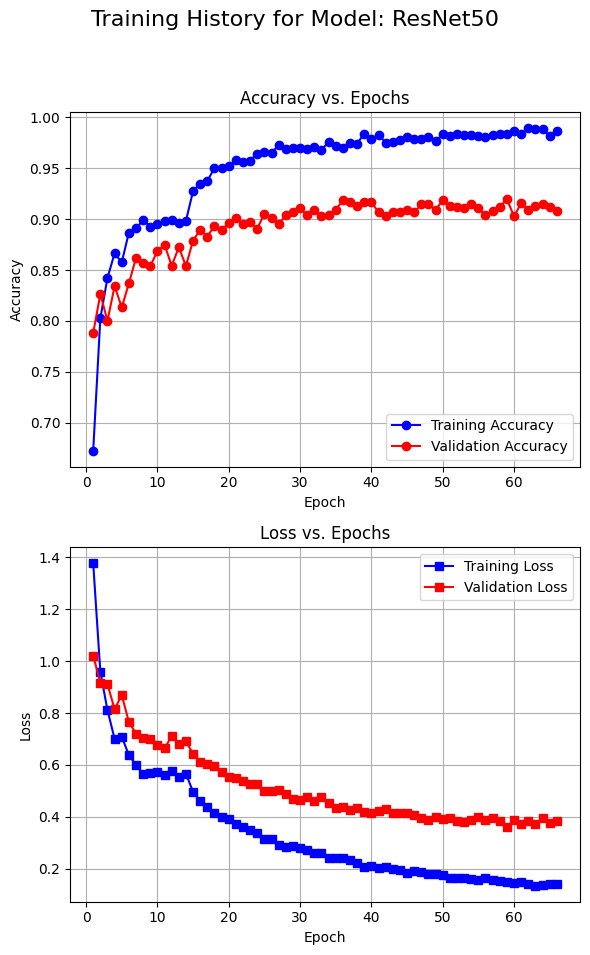

In [48]:
model_name_hist, history_object = list(all_models_histories.items())[0]
print(f"Generating history plot for: {model_name_hist}")
plot_model_history(history_object, model_name_hist)

  Generating confusion matrix for: ResNet50


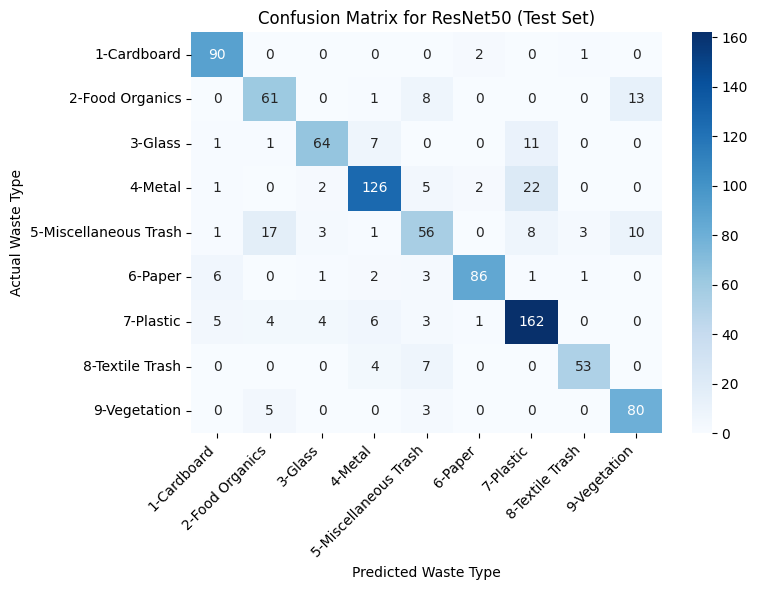

In [20]:
model_name_cm, result_data = list(all_models_results.items())[0]
if 'Test_True_Labels_Int' in result_data and 'Test_Predictions_Int' in result_data and 'Ordered_Class_Names' in result_data:
    print(f"  Generating confusion matrix for: {model_name_cm}")
    plot_single_confusion_matrix(
        result_data['Test_True_Labels_Int'],
        result_data['Test_Predictions_Int'],
        result_data['Ordered_Class_Names'],
        model_name_cm
    )

# ResNet101 training + eval

In [21]:
train_and_evaluate_model("ResNet101", PRETRAINED_MODELS_TO_USE["ResNet101"])


--- Processing Model: ResNet101 ---
Creating data pipelines for ResNet101
Pipelines created
Building model with base ResNet101
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
  Freezing layers of the base model ResNet101...


Model: "ResNet101_WasteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_1 (Dense)          │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_batch_norm_1             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_relu_1 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_1 (Dropout)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probabilities (Dense)    │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,186,057 (164.74 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5609 - loss: 1.6525
Epoch 1: val_loss improved from inf to 1.06184, saving model to ./ResNet101_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 285ms/step - accuracy: 0.5615 - loss: 1.6509 - val_accuracy: 0.7895 - val_loss: 1.0618 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8077 - loss: 0.9587
Epoch 2: val_loss improved from 1.06184 to 0.90871, saving model to ./ResNet101_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step - accuracy: 0.8077 - loss: 0.9586 - val_accuracy: 0.8237 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8236 - loss: 0.8577
Epoch 3: val_loss improved from 0.90871 to 0.82281, saving model to ./ResNet101_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.8237 - loss: 0.8576 - val_accuracy: 0.8447 - val_loss: 0.8228 - learning_rate: 

## ResNet101

#### EPOCHS 61

#### Train Set: Loss=0.1327, Acc=0.9937, P=0.9931, R=0.9957, F1=0.9943, AUC=1.0000

#### Val. Set:  Loss=0.3986, Acc=0.9013, P=0.9067, R=0.9114, F1=0.9080, AUC=0.9944

#### Test Set:  Loss=0.7151, Acc=0.8019, P=0.7998, R=0.8078, F1=0.8023, AUC=0.9780


Generating history plot for: ResNet101


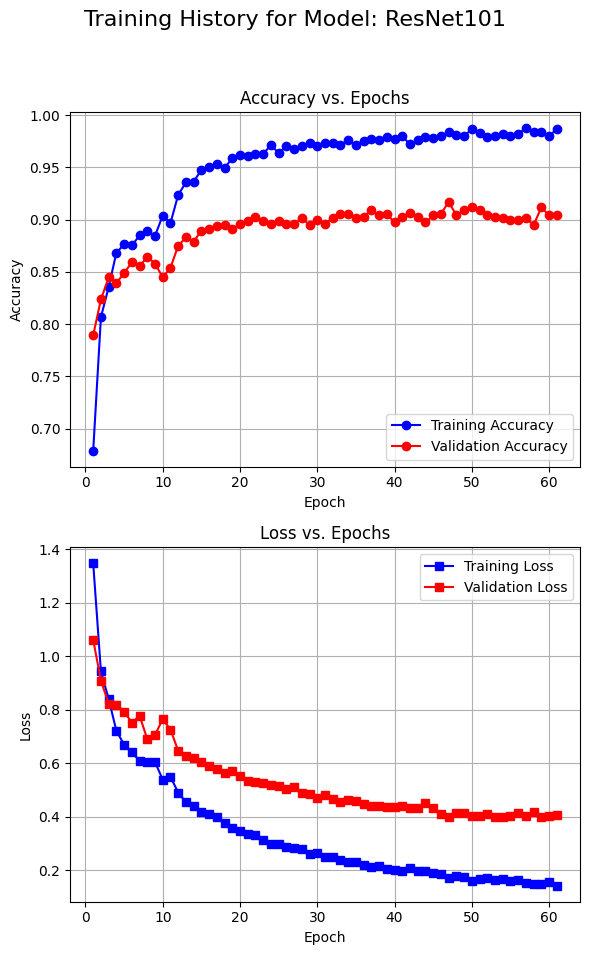

In [49]:
model_name_hist, history_object = list(all_models_histories.items())[1]
print(f"Generating history plot for: {model_name_hist}")
plot_model_history(history_object, model_name_hist)

  Generating confusion matrix for: ResNet101


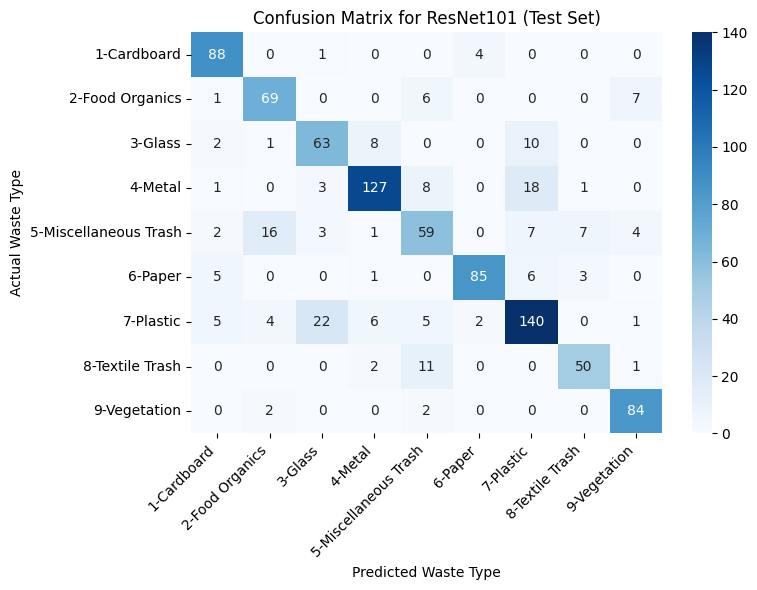

In [23]:
model_name_cm, result_data = list(all_models_results.items())[1]
if 'Test_True_Labels_Int' in result_data and 'Test_Predictions_Int' in result_data and 'Ordered_Class_Names' in result_data:
    print(f"  Generating confusion matrix for: {model_name_cm}")
    plot_single_confusion_matrix(
        result_data['Test_True_Labels_Int'],
        result_data['Test_Predictions_Int'],
        result_data['Ordered_Class_Names'],
        model_name_cm
    )

# EfficientNetB0 Training + Eval

In [24]:
train_and_evaluate_model("EfficientNetB0", PRETRAINED_MODELS_TO_USE["EfficientNetB0"])


--- Processing Model: EfficientNetB0 ---
Creating data pipelines for EfficientNetB0
Pipelines created
Building model with base EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Freezing layers of the base model EfficientNetB0...


Model: "EfficientNetB0_WasteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_1 (Dense)          │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_batch_norm_1             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_relu_1 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_1 (Dropout)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probabilities (Dense)    │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,844 (16.71 MB)

 Trainable params: 330,761 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5834 - loss: 1.6732
Epoch 1: val_loss improved from inf to 0.96308, saving model to ./EfficientNetB0_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 76s 279ms/step - accuracy: 0.5839 - loss: 1.6715 - val_accuracy: 0.8066 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8235 - loss: 0.9094
Epoch 2: val_loss improved from 0.96308 to 0.92324, saving model to ./EfficientNetB0_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.8235 - loss: 0.9094 - val_accuracy: 0.8250 - val_loss: 0.9232 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8531 - loss: 0.7905
Epoch 3: val_loss improved from 0.92324 to 0.86377, saving model to ./EfficientNetB0_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.8531 - loss: 0.7905 - val_accuracy: 0.8421 - val_loss: 0.8638 - 

## EfficientNetB0

#### EPOCHS 65

#### Train Set: Loss=0.1281, Acc=0.9990, P=0.9994, R=0.9992, F1=0.9993, AUC=1.0000

#### Val. Set:  Loss=0.3986, Acc=0.9197, P=0.9202, R=0.9205, F1=0.9195, AUC=0.9943

#### Test Set:  Loss=0.7526, Acc=0.8197, P=0.8242, R=0.8194, F1=0.8179, AUC=0.9800

Generating history plot for: EfficientNetB0


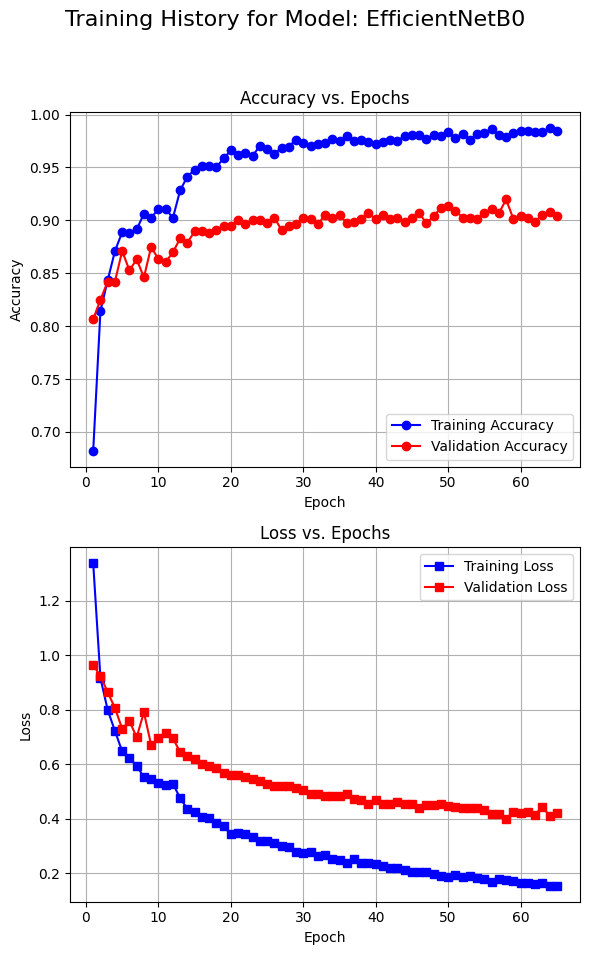

In [50]:
model_name_hist, history_object = list(all_models_histories.items())[2]
print(f"Generating history plot for: {model_name_hist}")
plot_model_history(history_object, model_name_hist)

  Generating confusion matrix for: EfficientNetB0


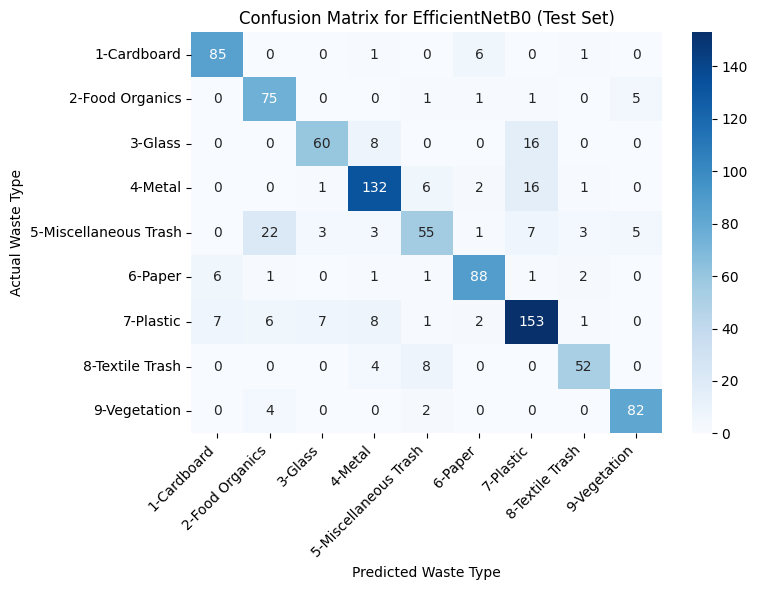

In [26]:
model_name_cm, result_data = list(all_models_results.items())[2]
if 'Test_True_Labels_Int' in result_data and 'Test_Predictions_Int' in result_data and 'Ordered_Class_Names' in result_data:
    print(f"  Generating confusion matrix for: {model_name_cm}")
    plot_single_confusion_matrix(
        result_data['Test_True_Labels_Int'],
        result_data['Test_Predictions_Int'],
        result_data['Ordered_Class_Names'],
        model_name_cm
    )

# VGG16 Training + Eval

In [27]:
train_and_evaluate_model("VGG16", PRETRAINED_MODELS_TO_USE["VGG16"])


--- Processing Model: VGG16 ---
Creating data pipelines for VGG16
Pipelines created
Building model with base VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Freezing layers of the base model VGG16...


Model: "VGG16_WasteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_1 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_batch_norm_1             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_relu_1 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_1 (Dropout)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probabilities (Dense)    │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,353 (56.65 MB)

 Trainable params: 134,153 (524.04 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4543 - loss: 1.8670
Epoch 1: val_loss improved from inf to 1.21404, saving model to ./VGG16_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 64s 272ms/step - accuracy: 0.4550 - loss: 1.8651 - val_accuracy: 0.6895 - val_loss: 1.2140 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7290 - loss: 1.0389
Epoch 2: val_loss improved from 1.21404 to 1.02338, saving model to ./VGG16_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.7291 - loss: 1.0388 - val_accuracy: 0.7461 - val_loss: 1.0234 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7723 - loss: 0.9161
Epoch 3: val_loss improved from 1.02338 to 0.97932, saving model to ./VGG16_best_weights.weights.h5
190/190 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.7723 - loss: 0.9160 - val_accuracy: 0.7526 - val_loss: 0.9793 - learning_rate: 0.0010
Epoch

## EfficientNetB0

#### EPOCHS 77

#### Train Set: Loss=0.2018, Acc=0.9812, P=0.9803, R=0.9846, F1=0.9823, AUC=0.9997

#### Val. Set:  Loss=0.5003, Acc=0.8882, P=0.8911, R=0.8950, F1=0.8922, AUC=0.9895

#### Test Set:  Loss=0.8441, Acc=0.7746, P=0.7728, R=0.7786, F1=0.7716, AUC=0.9679

Generating history plot for: VGG16


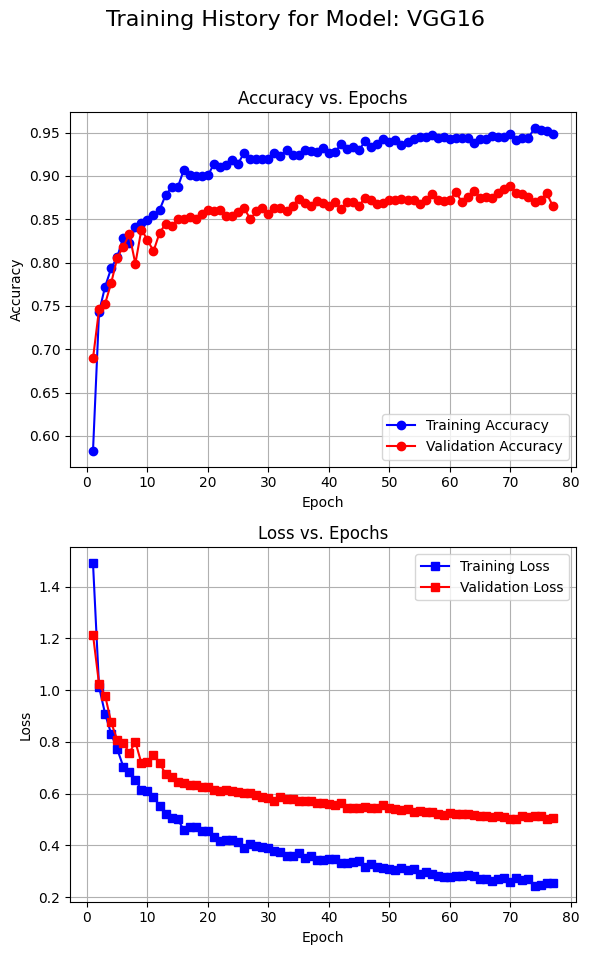

In [51]:
model_name_hist, history_object = list(all_models_histories.items())[3]
print(f"Generating history plot for: {model_name_hist}")
plot_model_history(history_object, model_name_hist)

  Generating confusion matrix for: VGG16


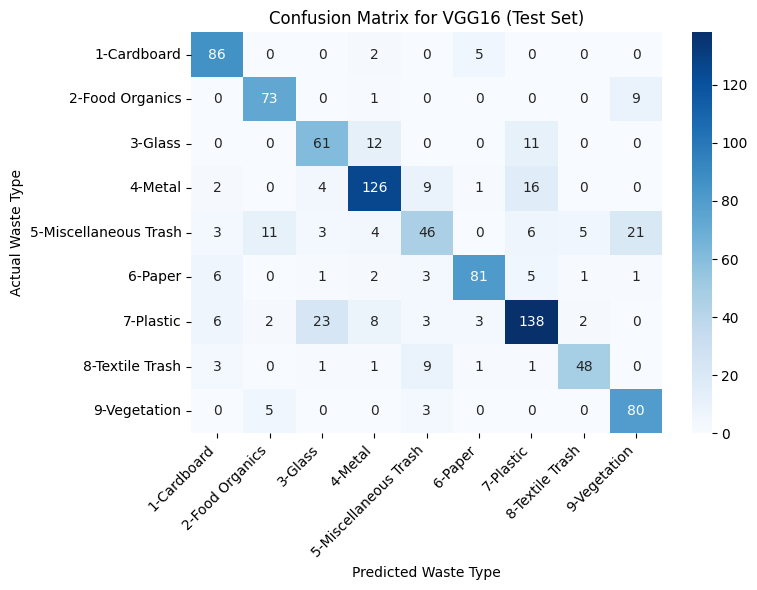

In [29]:
model_name_cm, result_data = list(all_models_results.items())[3]
if 'Test_True_Labels_Int' in result_data and 'Test_Predictions_Int' in result_data and 'Ordered_Class_Names' in result_data:
    print(f"  Generating confusion matrix for: {model_name_cm}")
    plot_single_confusion_matrix(
        result_data['Test_True_Labels_Int'],
        result_data['Test_Predictions_Int'],
        result_data['Ordered_Class_Names'],
        model_name_cm
    )

# Summarizing and Concluding

In [30]:
summary_list = []
metrics_to_display = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

for model_name_sum, results_for_model in all_models_results.items():
    row_data = {'Model': model_name_sum}
    for data_split_name in ['Train', 'Validation', 'Test']:
        for metric_name in metrics_to_display:
            column_header = f"{data_split_name} {metric_name}"
            row_data[column_header] = results_for_model[data_split_name].get(metric_name, float('nan'))
    summary_list.append(row_data)

performance_summary_df = pd.DataFrame(summary_list).set_index('Model')

pd.options.display.float_format = '{:.4f}'.format
print(performance_summary_df)

print()
best_f1_model_name = performance_summary_df['Test F1'].idxmax()
best_f1_score = performance_summary_df.loc[best_f1_model_name, 'Test F1']

best_auc_model_name = performance_summary_df['Test AUC'].idxmax()
best_auc_score = performance_summary_df.loc[best_auc_model_name, 'Test AUC']

best_acc_model_name = performance_summary_df['Test Accuracy'].idxmax()
best_acc_score = performance_summary_df.loc[best_acc_model_name, 'Test Accuracy']

print(f"Best Model based on Test F1-Score:{best_f1_model_name} (F1: {best_f1_score:.4f})")
print(f"Best Model based on Test AUC:     {best_auc_model_name} (AUC: {best_auc_score:.4f})")
print(f"Best Model based on Test Accuracy:{best_acc_model_name} (Accuracy: {best_acc_score:.4f})")



                Train Accuracy  Train Precision  Train Recall  Train F1  \
Model                                                                     
ResNet50                0.9961           0.9967        0.9975    0.9971   
ResNet101               0.9937           0.9931        0.9957    0.9943   
EfficientNetB0          0.9990           0.9994        0.9992    0.9993   
VGG16                   0.9812           0.9803        0.9846    0.9823   

                Train AUC  Validation Accuracy  Validation Precision  \
Model                                                                  
ResNet50           1.0000               0.9197                0.9238   
ResNet101          1.0000               0.9013                0.9067   
EfficientNetB0     1.0000               0.9197                0.9202   
VGG16              0.9997               0.8882                0.8911   

                Validation Recall  Validation F1  Validation AUC  \
Model                                           

# BEST MODEL

#### Best Model based on Test F1-Score:EfficientNetB0 (F1: 0.8179)
 
#### Best Model based on Test AUC:     EfficientNetB0 (AUC: 0.9800)

#### Best Model based on Test Accuracy:EfficientNetB0 (Accuracy: 0.8197)

Building model with base EfficientNetB0
  Freezing layers of the base model EfficientNetB0...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


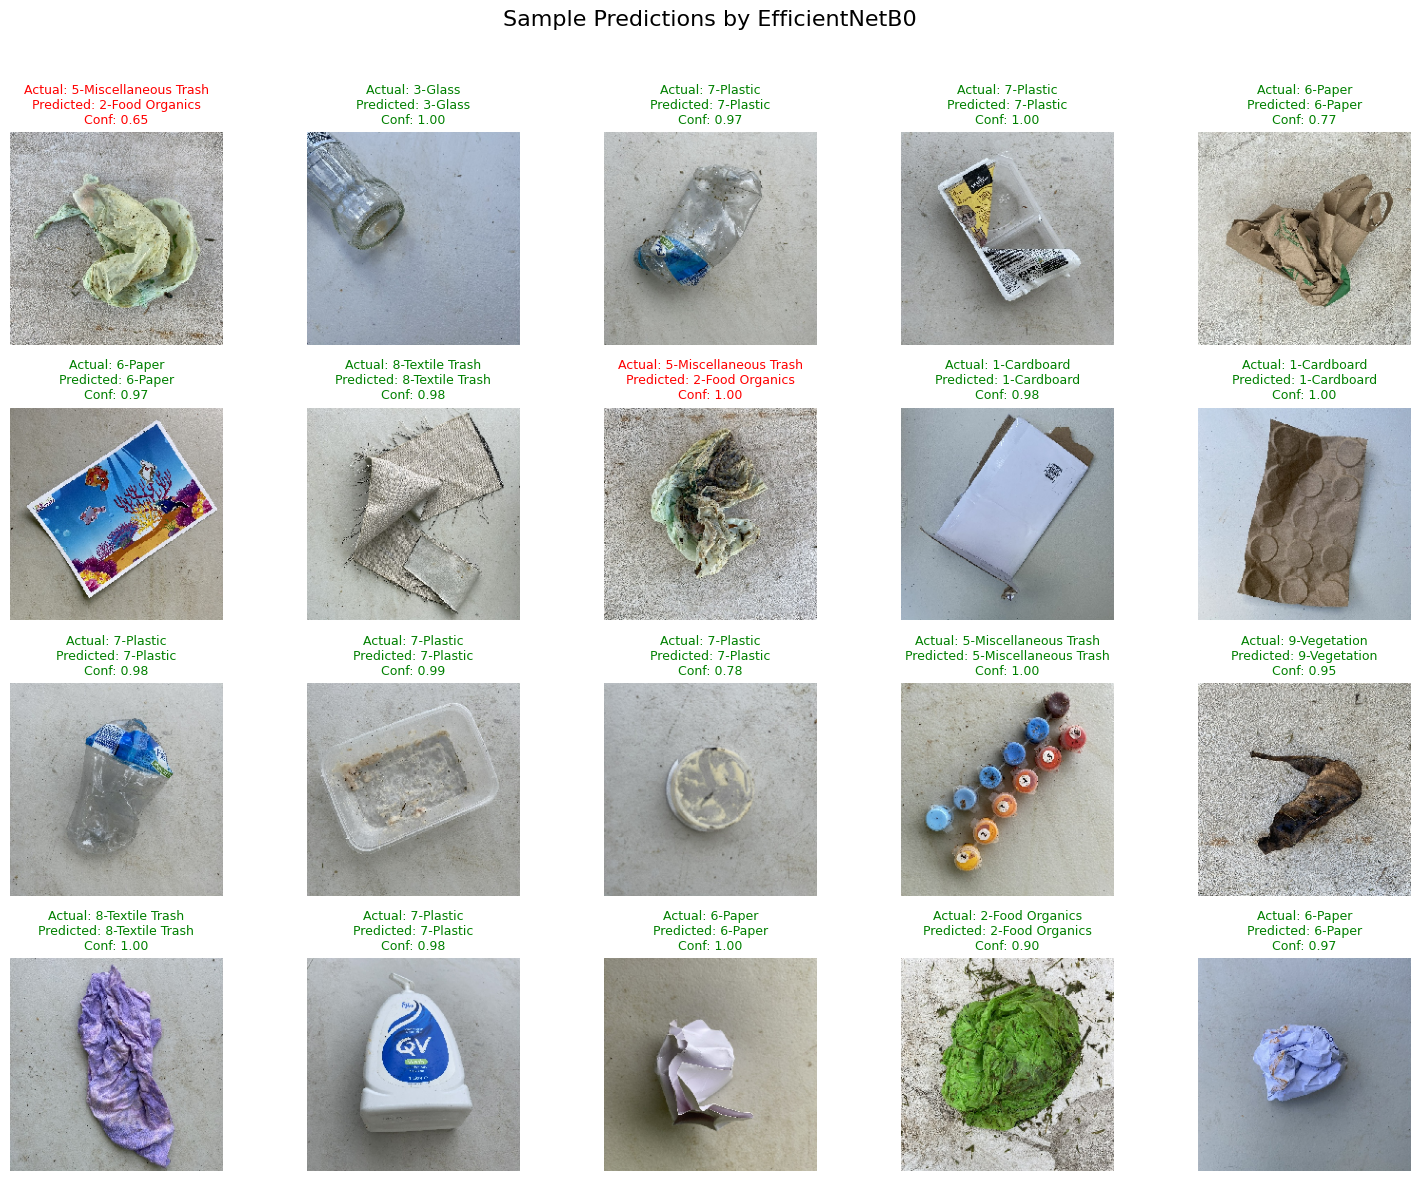

In [34]:
MODEL_FOR_SAMPLES = performance_summary_df['Test F1'].idxmax()
best_model_arch_info = PRETRAINED_MODELS_TO_USE[MODEL_FOR_SAMPLES]
sample_prediction_model = build_my_transfer_model(
    base_model_builder_fn=best_model_arch_info["builder"],
    input_image_shape=IMG_SHAPE,
    num_output_classes=NUM_CLASSES,
    custom_model_name=f"{MODEL_FOR_SAMPLES}_ForSamples"
)
# Load saved best weights
best_weights_file = f"./{MODEL_FOR_SAMPLES}_best_weights.weights.h5"
sample_prediction_model.load_weights(best_weights_file)
num_samples_to_show = 20
num_samples_to_show = min(num_samples_to_show, len(test_df))
sample_test_images_df = test_df.sample(n=num_samples_to_show, random_state=796986)
plt.figure(figsize=(15, 3 * ((num_samples_to_show - 1) // 5 + 1)))
plt.suptitle(f"Sample Predictions by {MODEL_FOR_SAMPLES}", fontsize=16)

for i, (idx_row, row_data) in enumerate(sample_test_images_df.iterrows()):
    img_path_sample = row_data['filepath']
    true_label_text_sample = row_data['label_text']

    img_binary = tf.io.read_file(img_path_sample)
    img_tensor_decoded = tf.image.decode_image(img_binary, channels=3, expand_animations=False)
    img_tensor_resized = tf.image.resize(img_tensor_decoded, [IMG_HEIGHT, IMG_WIDTH])
    img_tensor_resized.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    model_specific_preprocess = best_model_arch_info["preprocess_fn"]
    img_tensor_preprocessed = model_specific_preprocess(tf.identity(img_tensor_resized))
    img_batch_for_pred = tf.expand_dims(img_tensor_preprocessed, axis=0)

    pred_probabilities = sample_prediction_model.predict(img_batch_for_pred, verbose=0)[0]
    predicted_class_index = np.argmax(pred_probabilities)
    predicted_class_text = ORDERED_CLASS_NAMES_FROM_BINARIZER[predicted_class_index]
    prediction_confidence = pred_probabilities[predicted_class_index]

    plt.subplot(((num_samples_to_show -1) // 5 + 1), 5, i + 1)
    display_image = keras.utils.load_img(img_path_sample, target_size=IMG_SIZE)
    plt.imshow(display_image)

    title_color = "green" if true_label_text_sample == predicted_class_text else "red"
    plt.title(f"Actual: {true_label_text_sample}\nPredicted: {predicted_class_text}\nConf: {prediction_confidence:.2f}",
                color=title_color, fontsize=9)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
